# Creating a New Thorn, Part 2

So far we've created an empty thorn which does nothing. Never before did doing nothing feel like such an accomplishment!

We can use it as a template for something more useful. To that end, we're going to create a thorn which computes an "energy," the sum of the squares of the wave velocities at each point on the grid. First, we create the source file itself. It's simple enough.

In [1]:
funwave_dir='/home/ejwest/ETK/CactusFW2'
sim_dir='/home/ejwest/ETK/simulations'
thorn_dir='/home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc'

In [2]:
%%writefile {thorn_dir}/src/energy.cc
// We pretty much always want to include these 3 headers
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

void compute_energy(CCTK_ARGUMENTS) // Cactus functions always have this prototype
{
    DECLARE_CCTK_ARGUMENTS; // Declare all grid functions (from interface.ccl)
    DECLARE_CCTK_PARAMETERS; // Declare all parameters (from param.ccl)
    
    // Note that even though this is really a 2-d calculation, Cactus
    // thinks of it as 3-d with 1 zone in the z direction.
    for(int k=0; k < cctk_lsh[2]; k++) // loop over the z direction 
    { 
        for(int j=0; j < cctk_lsh[1]; j++) // loop over the y direction
        {
            for(int i=0; i < cctk_lsh[0]; i++) // loop over the x direction
            {
                int cc = CCTK_GFINDEX3D(cctkGH, i, j, k);
                energy[cc] = u[cc]*u[cc] + v[cc]*v[cc];
            }
        }
    }
}

Writing /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc/src/energy.cc


Next we update the makefile so that it will build. Are we done? Let's try to compile.

In [3]:
%%writefile {thorn_dir}/src/make.code.defn
# Main make.code.defn file for thorn Energy

# Source files in this directory
SRCS = energy.cc

# Subdirectories containing source files
SUBDIRS =


Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc/src/make.code.defn


In [4]:
%cd {funwave_dir}
!time ./simfactory/bin/sim build -j2 --thornlist=thornlists/my_thorns.th

/home/ejwest/ETK/CactusFW2
Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet Ca

   AEILocalInterp
          0 Global, 0 Restricted, 1 Private parameters
   Boundary
          0 Global, 8 Restricted, 0 Private parameters
   Cactus
          0 Global, 6 Restricted, 13 Private parameters
   Carpet
          0 Global, 4 Restricted, 94 Private parameters
   CarpetEvolutionMask
          0 Global, 0 Restricted, 6 Private parameters
   CarpetIOASCII
          0 Global, 0 Restricted, 63 Private parameters
   CarpetIOBasic
          0 Global, 0 Restricted, 15 Private parameters
   CarpetIOHDF5
          0 Global, 0 Restricted, 77 Private parameters
   CarpetIOScalar
          0 Global, 0 Restricted, 9 Private parameters
   CarpetInterp
          0 Global, 0 Restricted, 5 Private parameters
   CarpetInterp2
          0 Global, 0 Restricted, 3 Private parameters
   CarpetLib
          0 Global, 5 Restricted, 31 Private parameters
   CarpetMask
          0 Global, 0 Restricted, 8 Private parameters
   CarpetReduce
          0 Global, 0 Restricted, 3 Private parameters
   Carp

Checking status of thorn CarpetIOBasic
Checking status of thorn HDF5
Checking status of thorn CarpetIOHDF5
Checking status of thorn CarpetIOScalar
Checking status of thorn CarpetInterp
Checking status of thorn CarpetInterp2
Checking status of thorn CarpetMask
Checking status of thorn CarpetReduce
Checking status of thorn CarpetRegrid
Checking status of thorn CarpetRegrid2
Checking status of thorn CarpetSlab
Checking status of thorn CarpetTracker
Checking status of thorn CoordBase
Checking status of thorn CartGrid3D
Checking status of thorn SphericalSurface
Checking status of thorn Dissipation
Checking status of thorn EnergyCalc
COMPILING FunwaveUtils/EnergyCalc/src/energy.cc
/home/ejwest/ETK/CactusFW2/configs/sim/build/EnergyCalc/energy.cc: In function ‘void compute_energy(cGH*)’:
/home/ejwest/ETK/CactusFW2/configs/sim/build/EnergyCalc/energy.cc:20:17: error: ‘energy’ was not declared in this scope
                 energy[cc] = u[cc]*u[cc] + v[cc]*v[cc];
                 ^~~~~~
/home/e

Why did it fail? Two reasons. First, the grid function "energy" was not defined. Second, the code did not know how to access the velocity fields, "u" and "v."

To overcome the first problem, we decalare the "energy_group" below. To fix the second, we simply inherit from thorn Funwave where the velocities "u" and "v" are defined.

In [5]:
%%writefile {thorn_dir}/interface.ccl
## Interface definitions for thorn Energy
inherits: Funwave
## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: EnergyCalc

## the groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. timelevels, tags such as the
## Prolongation=None tag. The type tag can take on the values
## GF, Scalar, or Array.

## Note that the number of timelevels can be an integer parameter
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, force2
#}

cctk_real energy_group type=GF
{
    energy
}

## Scalars are single variables that are available on all processors.
#{
#  scalar1, scalar2
#}


Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc/interface.ccl


With this change, everything should compile...

In [6]:
!time ./simfactory/bin/sim build -j2 --thornlist=thornlists/my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet CarpetLib MPI 
   CarpetInter

           Implements: SymBase
           0 Public, 0 Protected, 0 Private variable groups
   SystemTopology
           Implements: SystemTopology
           0 Public, 0 Protected, 0 Private variable groups
   TestCarpetGridInfo
           Implements: TestCarpetGridInfo
           0 Public, 0 Protected, 0 Private variable groups
   TestLoopControl
           Implements: TestLoopControl
           Inherits:  grid 
           0 Public, 0 Protected, 3 Private variable groups
   Time
           Implements: time
           1 Public, 0 Protected, 1 Private variable groups
   Timers
           Implements: Timers
           0 Public, 0 Protected, 0 Private variable groups
   Tridiagonal
           Implements: tridiagonal
           Inherits:  grid 
           2 Public, 0 Protected, 4 Private variable groups
   Tridiagonal2
           Implements: tridiagonal
           Inherits:  grid 
           2 Public, 0 Protected, 1 Private variable groups
   Vectors
           Implements: Vectors
        

MPI selected, but MPI_DIR is not set. Computing settings...
Found MPI compiler wrapper at /usr/bin/mpic++!
Successfully configured MPI.
Finished running configuration script for thorn MPI.

********************************************************************************
Running configuration script for thorn HDF5:
Additional requested language support:  Fortran
HDF5 selected, but HDF5_DIR not set. Checking pkg-config ...
HDF5 found: /usr
Finished running configuration script for thorn HDF5.
Checking consistency...
Creating Thorn-Flesh bindings...
   Creating implementation bindings...
   Creating parameter bindings...
   Creating variable bindings...
   Creating schedule bindings...
   Creating function bindings...
CST finished.
Checking status of thorn AEILocalInterp
Checking status of thorn Boundary
Checking status of thorn CycleClock
Checking status of thorn Vectors
Checking status of thorn zlib
Checking status of thorn hwloc
Checking status of thorn LoopControl
Checking status of t

So far so good. We've created a new thorn, including all the boiler plate code. We also filled in some source code and succeeded in compiling it. That's great. The only problem is, our thorn won't actually run because it's not scheduled to do so.

In [7]:
%%writefile {thorn_dir}/schedule.ccl
## Schedule definitions for thorn Energy

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

schedule compute_energy in CCTK_ANALYSIS
{
    LANG: C
} "Compute the Energy for Analysis" # This comment is required!

Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc/schedule.ccl


What does CCTK_ANALYSIS mean? Cactus schedules it's work in several bins. While there are many of them, here we only consider three:

1) CCTK_INITIAL - This runs once at the beginning. Initialize your grid functions here

2) CCTK_EVOL - Evolve a single timestep forward. This step will run repeatedly until the simulation finishes. Actually, this is rarely used directly. Usually, MoL_CalcRHS is used instead. More on that in a little bit.

3) CCTK_ANALYSIS - Called right before output routines. This ensures values are filled in sensibly. Call it to calculate values that you want to look at, but which aren't necessarily needed for the evolution.

In [8]:
!time ./simfactory/bin/sim build -j2 --thornlist=thornlists/my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet CarpetLib MPI 
   CarpetInter

Parsing parameter files...
   AEILocalInterp
          0 Global, 0 Restricted, 1 Private parameters
   Boundary
          0 Global, 8 Restricted, 0 Private parameters
   Cactus
          0 Global, 6 Restricted, 13 Private parameters
   Carpet
          0 Global, 4 Restricted, 94 Private parameters
   CarpetEvolutionMask
          0 Global, 0 Restricted, 6 Private parameters
   CarpetIOASCII
          0 Global, 0 Restricted, 63 Private parameters
   CarpetIOBasic
          0 Global, 0 Restricted, 15 Private parameters
   CarpetIOHDF5
          0 Global, 0 Restricted, 77 Private parameters
   CarpetIOScalar
          0 Global, 0 Restricted, 9 Private parameters
   CarpetInterp
          0 Global, 0 Restricted, 5 Private parameters
   CarpetInterp2
          0 Global, 0 Restricted, 3 Private parameters
   CarpetLib
          0 Global, 5 Restricted, 31 Private parameters
   CarpetMask
          0 Global, 0 Restricted, 8 Private parameters
   CarpetReduce
          0 Global, 0 Restricted, 3

Checking status of thorn CarpetIOASCII
Checking status of thorn CarpetIOBasic
Checking status of thorn HDF5
Checking status of thorn CarpetIOHDF5
Checking status of thorn CarpetIOScalar
Checking status of thorn CarpetInterp
Checking status of thorn CarpetInterp2
Checking status of thorn CarpetMask
Checking status of thorn CarpetReduce
Checking status of thorn CarpetRegrid
Checking status of thorn CarpetRegrid2
Checking status of thorn CarpetSlab
Checking status of thorn CarpetTracker
Checking status of thorn CoordBase
Checking status of thorn CartGrid3D
Checking status of thorn SphericalSurface
Checking status of thorn Dissipation
Checking status of thorn EnergyCalc
COMPILING FunwaveUtils/EnergyCalc/src/energy.cc
Updating /home/ejwest/ETK/CactusFW2/configs/sim/lib/libthorn_EnergyCalc.a
Checking status of thorn Fortran
Checking status of thorn Funwave
Checking status of thorn FunwaveCoord
Checking status of thorn FunwaveMesh
Checking status of thorn IOASCII
Checking status of thorn IOBa

Now, let's find out what our code does! First, we'll need to create a par file. It will be similar to the one we created in the first lesson. We will, however, make a few small modifications.

In [9]:
%%writefile {funwave_dir}/par/funwave2.par

#Reorder the parameters for easy comparison to the input.txt in example 3
ActiveThorns = "
  CoordBase FunWave FunwaveCoord CartGrid3D Carpet CarpetIOASCII
  CartGrid3D IOUtil CarpetIOBasic CarpetSlab Boundary SymBase MoL
  CarpetReduce LocalReduce InitBase CarpetLib LoopControl Tridiagonal
  CarpetIOScalar EnergyCalc "

#----------------------------------------------------
# Flesh and CCTK parameters
#----------------------------------------------------

# flesh
Cactus::cctk_run_title = "Test Run"
Cactus::cctk_show_schedule = "yes"
Cactus::cctk_itlast = 300
Cactus::allow_mixeddim_gfs = "yes"

# CartGrid3D
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

CoordBase::boundary_size_x_lower     = 3
CoordBase::boundary_size_x_upper     = 3
CoordBase::boundary_size_y_lower     = 3
CoordBase::boundary_size_y_upper     = 3
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_x_lower = 1
CoordBase::boundary_shiftout_x_upper = 1
CoordBase::boundary_shiftout_y_lower = 1
CoordBase::boundary_shiftout_y_upper = 1
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# Carpet
Carpet::domain_from_coordbase = "yes"
Carpet::ghost_size_x = 3
Carpet::ghost_size_y = 3
Carpet::ghost_size_z = 1
carpet::adaptive_stepsize = yes

# MoL
MoL::ODE_Method = "RK3"
MoL::disable_prolongation        = "yes"

# the output dir will be named after the parameter file name
IO::out_dir = $parfile
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"

#IOASCII::out1D_every = 1
#IOASCII::out1d_vars = "FunWave::eta Funwave::depth"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 30
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

IOScalar::outScalar_every = 1
IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"

#& = "Funwave::eta"

#----------------------------------------------------
# Funwave parameters
#----------------------------------------------------

# Funwave depth 
FunWave::depth_file_offset_x = 3
FunWave::depth_file_offset_y = 3
FunWave::depth_type = "flat"
FunWave::depth_format = "ele"
FunWave::depth_file = "/tmp/__depth__.txt"
FunWave::depth_flat = 0.8
#Funwave::test_depth_shore_x = 80
#Funwave::test_depth_island_x = 40
#Funwave::test_depth_island_y = 40
FunWave::depth_xslp = 10.0
FunWave::depth_slope = 0.05
FunWave::dt_size = 0
Funwave::generate_test_depth_data = true
Funwave::num_wave_components = 1
Funwave::wave_component_file = "/home/sbrandt/workspace/shi_funwave/example_2/fft/wavemk_per_amp_pha.txt"
Funwave::peak_period = 1

# import
Funwave::time_ramp = 1.0
Funwave::delta_wk = 0.5
Funwave::dep_wk = 0.45
Funwave::xc_wk = 3.0
Funwave::ywidth_wk = 10000.0
Funwave::tperiod = 1.0
Funwave::amp_wk = 0.0232
Funwave::theta_wk = 0.0
Funwave::freqpeak = 0.2
Funwave::freqmin = 0.1
Funwave::freqmax = 0.4
Funwave::hmo = 1.0
Funwave::gammatma = 5.0
Funwave::thetapeak = 10.0
Funwave::sigma_theta = 15.0

# Funwave wind forcing
Funwave::wind_force = false
Funwave::use_wind_mask = false
Funwave::num_time_wind_data = 2
Funwave::timewind[0] = 0
Funwave::wu[0] = 25
Funwave::wv[0] = 50
Funwave::timewind[1] = 1000
Funwave::wu[1] = 100
Funwave::wv[1] = 100
Funwave::boundary = funwave

# Funwave wave maker
FunWave::wavemaker_type = "ini_gau"
FunWave::xc = 26.5
FunWave::yc = 26.9
FunWave::amp =  2.0
FunWave::wid =  1
Funwave::wdep = 0.78
Funwave::xwavemaker = 25.0

# Funwave sponge 
FunWave::sponge_on = false
FunWave::sponge_west_width = 2.0
FunWave::sponge_east_width = 2.0
FunWave::sponge_north_width = 0.0
FunWave::sponge_south_width = 0.0
FunWave::sponge_decay_rate = 0.9
FunWave::sponge_damping_magnitude = 5.0

# Funwave dispersion (example 3 enables dispersion)
FunWave::dispersion_on = "true"
FunWave::gamma1 = 1.0
FunWave::gamma2 = 1.0
FunWave::gamma3 = 1.0
FunWave::beta_ref = -0.531
FunWave::swe_eta_dep = 0.80
FunWave::cd = 0.0

# Funwave numerics (MoL parameter controls time integration scheme)
FunWave::reconstruction_scheme = "fourth"
FunWave::riemann_solver = "HLLC"
FunWave::dtfac = 0.5
FunWave::froudecap = 10.0
FunWave::mindepth = 0.001
FunWave::mindepthfrc = 0.001
FunWave::enable_masks = "true"
Funwave::estimate_dt_on = "true"

FunwaveCoord::spherical_coordinates = false

ActiveThorns = "CarpetIOHDF5"
IOHDF5::out2D_xyplane_z = 0 
IOHDF5::out2D_every = 10
IOHDF5::out2D_vars = " 
  FunWave::eta
  FunWave::u
  FunWave::v
  Grid::Coordinates{out_every=1000000000}
"
IOHDF5::out2D_xz = no
IOHDF5::out2D_yz = no

Overwriting /home/ejwest/ETK/CactusFW2/par/funwave2.par


What, exactly, did we change? We can use diff to find out.

In [10]:
!diff {funwave_dir}/par/funwave.par {funwave_dir}/par/funwave2.par

7c7
<   CarpetIOScalar "
---
>   CarpetIOScalar EnergyCalc "
61c61
< IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v"
---
> IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"
68c68
< IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v"
---
> IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"
74c74
< IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v"
---
> IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"


Now prepare to run. First, delete any previous versions of the simulation that might exist.

In [11]:
%rm -rf {sim_dir}/funwave2

And then run...

In [12]:
%cd {funwave_dir}
!./simfactory/bin/sim create-run funwave2 --parfile=par/funwave2.par --procs=2

/home/ejwest/ETK/CactusFW2
Parameter file: /home/ejwest/ETK/CactusFW2/par/funwave2.par
Skeleton Created
Job directory: "/home/ejwest/ETK/simulations/funwave2"
Executable: "/home/ejwest/ETK/CactusFW2/exe/cactus_sim"
Option list: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/cfg/OptionList"
Submit script: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/run/SubmitScript"
Run script: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/run/RunScript"
Parameter file: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/par/funwave2.par"
Simulation name: funwave2
Assigned restart id: 0 
Running simulation funwave2
Preparing:
+ set -e
+ cd /home/ejwest/ETK/simulations/funwave2/output-0000-active
+ echo Checking:
Checking:
+ pwd
/home/ejwest/ETK/simulations/funwave2/output-0000-active
+ hostname
newton
+ date
Sun Apr 28 19:53:46 CDT 2019
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=2
+ export GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=2
+ env


INFO (CycleClock): Calibrated CycleClock: 0.303711 ns per clock tick (3.29261 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 2 for architecture SSE2 (64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
-------------------------------------------------------

Segmentation fault (core dumped)
Sun Apr 28 19:53:47 CDT 2019
Simfactory Done at date: 0


Where did things go wrong? We can re-run the simulation with gdb and get a stack trace to see.

In [13]:
!gdb ./exe/cactus_sim --eval-command="run par/funwave2.par" --eval-command=where < /dev/null

GNU gdb (Ubuntu 8.1-0ubuntu3) 8.1.0.20180409-git
Copyright (C) 2018 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.  Type "show copying"
and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
<http://www.gnu.org/software/gdb/documentation/>.
For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from ./exe/cactus_sim...done.
Starting program: /home/ejwest/ETK/CactusFW2/exe/cactus_sim par/funwave2.par
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
[New Thread 0x7ff

INFO (CycleClock): Calibrated CycleClock: 0.303708 ns per clock tick (3.29264 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 2 for architecture SSE2 (64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
-------------------------------------------------------

#9  0x00005555555f715b in CCTK_ScheduleTraverse (
    where=where@entry=0x555555e0ca4b "CCTK_ANALYSIS", 
    GH=GH@entry=0x5555567c2980, 
    CallFunction=0x555555a636c0 <Carpet::CallFunction(void*, cFunctionData*, void*)>)
    at /home/ejwest/ETK/CactusFW2/configs/sim/build/Cactus/main/ScheduleInterface.c:902
#10 0x0000555555a1372e in Carpet::ScheduleTraverse (
    name=name@entry=0x555555e0ca4b "CCTK_ANALYSIS", 
    cctkGH=cctkGH@entry=0x5555567c2980, where=0x555555e7fcb3 "CallAnalysis", 
    this=<optimized out>, this=<optimized out>, this=<optimized out>, 
---Type <return> to continue, or q <return> to quit---    this=<optimized out>)
    at /home/ejwest/ETK/CactusFW2/configs/sim/build/Carpet/Initialise.cc:1391
#11 0x0000555555a16056 in Carpet::CallAnalysis (did_recover=false, 
    cctkGH=0x5555567c2980)
    at /home/ejwest/ETK/CactusFW2/configs/sim/build/Carpet/Initialise.cc:632
#12 Carpet::Initialise (fc=0x7fffffffdb90)
    at /home/ejwest/ETK/CactusFW2/configs/sim/build/Carpet/I

The segfault occurs when we first attempt to write the energy variable. The problem is, Cactus has not allocated storage
for the variable. To do that, we must edit the schedule file and add a storage declaration for the energy_group.

In [14]:
%%writefile {thorn_dir}/schedule.ccl
## Schedule definitions for thorn Energy

storage: energycalc::energy_group

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

schedule compute_energy in CCTK_ANALYSIS
{
    LANG: C
} "Compute the Energy for Analysis" # This comment is required!

Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/EnergyCalc/schedule.ccl


With this change, we need to rebuild.

In [15]:
!time ./simfactory/bin/sim build -j2 --thornlist=thornlists/my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet CarpetLib MPI 
   CarpetInter

           Implements: SphericalSurface
           Inherits:  grid 
           9 Public, 0 Protected, 1 Private variable groups
   SymBase
           Implements: SymBase
           0 Public, 0 Protected, 0 Private variable groups
   SystemTopology
           Implements: SystemTopology
           0 Public, 0 Protected, 0 Private variable groups
   TestCarpetGridInfo
           Implements: TestCarpetGridInfo
           0 Public, 0 Protected, 0 Private variable groups
   TestLoopControl
           Implements: TestLoopControl
           Inherits:  grid 
           0 Public, 0 Protected, 3 Private variable groups
   Time
           Implements: time
           1 Public, 0 Protected, 1 Private variable groups
   Timers
           Implements: Timers
           0 Public, 0 Protected, 0 Private variable groups
   Tridiagonal
           Implements: tridiagonal
           Inherits:  grid 
           2 Public, 0 Protected, 4 Private variable groups
   Tridiagonal2
           Implements: tridiagonal

Found hwloc in NO_BUILD
Finished running configuration script for thorn HWLOC.

********************************************************************************
Running configuration script for thorn MPI:
MPI selected, but MPI_DIR is not set. Computing settings...
Found MPI compiler wrapper at /usr/bin/mpic++!
Successfully configured MPI.
Finished running configuration script for thorn MPI.

********************************************************************************
Running configuration script for thorn HDF5:
Additional requested language support:  Fortran
HDF5 selected, but HDF5_DIR not set. Checking pkg-config ...
HDF5 found: /usr
Finished running configuration script for thorn HDF5.
Checking consistency...
Creating Thorn-Flesh bindings...
   Creating implementation bindings...
   Creating parameter bindings...
   Creating variable bindings...
   Creating schedule bindings...
   Creating function bindings...
CST finished.
Checking status of thorn AEILocalInterp
Checking status 

Again, remove old copies, and then run.

In [16]:
%rm -rf {sim_dir}/funwave2
!./simfactory/bin/sim create-run funwave2 --parfile=par/funwave2.par --procs=2

Parameter file: /home/ejwest/ETK/CactusFW2/par/funwave2.par
Skeleton Created
Job directory: "/home/ejwest/ETK/simulations/funwave2"
Executable: "/home/ejwest/ETK/CactusFW2/exe/cactus_sim"
Option list: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/cfg/OptionList"
Submit script: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/run/SubmitScript"
Run script: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/run/RunScript"
Parameter file: "/home/ejwest/ETK/simulations/funwave2/SIMFACTORY/par/funwave2.par"
Simulation name: funwave2
Assigned restart id: 0 
Running simulation funwave2
Preparing:
+ set -e
+ cd /home/ejwest/ETK/simulations/funwave2/output-0000-active
+ echo Checking:
Checking:
+ pwd
/home/ejwest/ETK/simulations/funwave2/output-0000-active
+ hostname
newton
+ date
Sun Apr 28 19:54:48 CDT 2019
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=2
+ export GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=2
+ env
+ sort
+ echo Starting:
Sta

INFO (CycleClock): Calibrated CycleClock: 0.303711 ns per clock tick (3.2926 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 2 for architecture SSE2 (64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------

        3     1.048 | 1.252968e-75    0.6435655 |   -0.7827099    0.7827247 |   -0.7908120    0.7945910 | -2.204493e-13    1.7406879
        4     1.071 | 3.407719e-72    1.0454892 |   -0.9871958    0.9871304 |   -1.0078458    1.0085949 | -8.400691e-14    1.5989647
        5     1.094 | 1.604125e-69    1.4747958 |   -1.1744423    1.1742063 |   -1.1909363    1.1836515 | -1.710410e-15    1.4476202
        6     1.117 | 9.971571e-68    1.8613640 |   -1.3292681    1.3289617 |   -1.3316063    1.3201955 | -1.152414e-14    1.2961226
        7     1.140 | 1.941100e-66    2.2309224 |   -1.4464243    1.4460941 |   -1.4436961    1.4892265 | -7.675744e-14    1.1507342
        8     1.162 | 1.669831e-65    2.6972228 |   -1.5469224    1.5458777 |   -1.6224632    1.6048745 | -9.317621e-16    1.0141344
        9     1.185 | 9.356162e-65    3.0186741 |   -1.6090563    1.6066068 |   -1.7050094    1.6735034 | -3.912694e-15    0.8880859
       10     1.208 | 4.132069e-64    3.4272402 |   -1.6386679    1.6

       57     2.317 | 5.133435e-49    3.7183785 |   -1.9281143    0.2444847 |   -1.7139568    0.1615919 |   -0.3285827    0.7226012
       58     2.339 | 8.345324e-49    3.3485284 |   -1.8296830    0.2295761 |   -1.8266446    0.1224592 |   -0.3246903    0.6970215
       59     2.361 | 1.360929e-48    3.6954559 |   -1.9223186    0.2215102 |   -1.7805748    0.1314378 |   -0.3213394    0.6788942
-----------------------------------------------------------------------------------------------------------------------------------
Iteration      Time |        ENERGYCALC::energy |                FUNWAVE::u |                FUNWAVE::v |              FUNWAVE::eta
                    |      minimum      maximum |      minimum      maximum |      minimum      maximum |      minimum      maximum
-----------------------------------------------------------------------------------------------------------------------------------
       60     2.383 | 2.196822e-48    3.3852741 |   -1.8398102    0.2132160 

      108     3.522 | 3.524891e-39    2.1177411 |   -1.2195789    0.1392731 |   -1.2130160    0.1380853 |   -0.2491385    0.6046090
      109     3.547 | 5.360385e-39    2.1296966 |   -1.2106405    0.1394119 |   -1.2161139    0.1391630 |   -0.2563714    0.6048681
      110     3.573 | 8.140111e-39    2.1345543 |   -1.2105523    0.1405991 |   -1.2088572    0.1398793 |   -0.2634204    0.5969148
      111     3.599 | 1.234592e-38    2.0790798 |   -1.1996253    0.1408904 |   -1.2002563    0.1412257 |   -0.2703028    0.6002477
      112     3.625 | 1.870149e-38    2.0757570 |   -1.1949366    0.1415017 |   -1.2005551    0.1469123 |   -0.2770321    0.5909917
      113     3.651 | 2.829842e-38    2.0387139 |   -1.1925346    0.1426095 |   -1.1903770    0.1563096 |   -0.2836290    0.5928934
      114     3.678 | 4.278984e-38    2.0026473 |   -1.1792564    0.1424504 |   -1.1865481    0.1627133 |   -0.2900687    0.5827707
      115     3.704 | 6.455807e-38    1.9657570 |   -1.1790620    0.1429598 

      161     4.982 | 4.339280e-30    0.9904971 |   -0.9950475    0.5143159 |   -0.9581211    0.4699518 |   -0.2250631    0.3655322
      162     5.011 | 6.236447e-30    1.0012591 |   -1.0004798    0.5242588 |   -0.9556712    0.4785557 |   -0.2245745    0.3673628
      163     5.039 | 8.942020e-30    0.9858870 |   -0.9928053    0.5317480 |   -0.9533465    0.4852857 |   -0.2235524    0.3643980
      164     5.068 | 1.281499e-29    1.0066146 |   -1.0032191    0.5366419 |   -0.9430352    0.4900613 |   -0.2219769    0.3619333
      165     5.096 | 1.832793e-29    1.0153108 |   -1.0075654    0.5388146 |   -0.9449306    0.4927810 |   -0.2197630    0.3643078
      166     5.125 | 2.615805e-29    0.9981271 |   -0.9990207    0.5381897 |   -0.9402740    0.4934024 |   -0.2168776    0.3603049
      167     5.153 | 3.732274e-29    1.0081303 |   -1.0040400    0.5346811 |   -0.9333726    0.4918837 |   -0.2133366    0.3587039
      168     5.182 | 5.316366e-29    1.0148701 |   -1.0073972    0.5283035 

      216     6.609 | 4.994859e-22    0.6822537 |   -0.7945963    0.3743043 |   -0.7729980    0.4411789 |   -0.1775975    0.3096066
      217     6.640 | 6.856887e-22    0.6734730 |   -0.7895058    0.3758773 |   -0.7679038    0.4429231 |   -0.1774639    0.3070860
      218     6.671 | 9.408128e-22    0.6705981 |   -0.7891180    0.3791573 |   -0.7681514    0.4459202 |   -0.1775547    0.3060241
      219     6.702 | 1.289361e-21    0.6611764 |   -0.7807708    0.3818704 |   -0.7626188    0.4477128 |   -0.1777031    0.3036830
-----------------------------------------------------------------------------------------------------------------------------------
Iteration      Time |        ENERGYCALC::energy |                FUNWAVE::u |                FUNWAVE::v |              FUNWAVE::eta
                    |      minimum      maximum |      minimum      maximum |      minimum      maximum |      minimum      maximum
----------------------------------------------------------------------------

      267     8.237 | 1.682354e-15    0.4592265 |   -0.6776477    0.4063605 |   -0.6563925    0.4422116 |   -0.1582945    0.2236090
      268     8.269 | 2.203306e-15    0.4535193 |   -0.6734256    0.4059333 |   -0.6535384    0.4421553 |   -0.1577800    0.2217224
      269     8.302 | 2.882688e-15    0.4565618 |   -0.6756800    0.4045318 |   -0.6554061    0.4411120 |   -0.1571127    0.2206535
      270     8.334 | 3.767146e-15    0.4504386 |   -0.6711322    0.4046642 |   -0.6501599    0.4390332 |   -0.1563702    0.2209410
      271     8.367 | 4.920619e-15    0.4503632 |   -0.6710783    0.4044379 |   -0.6510131    0.4387896 |   -0.1558859    0.2205042
      272     8.400 | 6.418069e-15    0.4497585 |   -0.6706263    0.4032953 |   -0.6504622    0.4380201 |   -0.1553208    0.2189918
      273     8.432 | 8.363849e-15    0.4414478 |   -0.6644033    0.4028924 |   -0.6438784    0.4362545 |   -0.1545145    0.2199283
      274     8.465 | 1.089069e-14    0.4460953 |   -0.6678908    0.4028691 

If all went well, it works! Now let's plot our energy function as we did in the Cactus-Funwave notebook.

In [17]:
%cd {sim_dir}/funwave2/output-0000/funwave2
%ls

/home/ejwest/ETK/simulations/funwave2/output-0000/funwave2
energy.average.asc   eta.iaverage.asc  u.count.asc     v.iaverage.asc
energy.count.asc     eta.icount.asc    u.iaverage.asc  v.icount.asc
energy.iaverage.asc  eta.inorm1.asc    u.icount.asc    v.inorm1.asc
energy.icount.asc    eta.inorm2.asc    u.inorm1.asc    v.inorm2.asc
energy.inorm1.asc    eta.maximum.asc   u.inorm2.asc    v.maximum.asc
energy.inorm2.asc    eta.minimum.asc   u.maximum.asc   v.minimum.asc
energy.maximum.asc   eta.norm1.asc     u.minimum.asc   v.norm1.asc
energy.minimum.asc   eta.norm2.asc     u.norm1.asc     v.norm2.asc
energy.norm1.asc     eta.norm_inf.asc  u.norm2.asc     v.norm_inf.asc
energy.norm2.asc     eta.sum.asc       u.norm_inf.asc  v.sum.asc
energy.norm_inf.asc  eta.xy.asc        u.sum.asc       v.xy.asc
energy.sum.asc       eta.xy.h5         u.xy.asc        v.xy.h5
energy.xy.asc        funwave2.par      u.xy.h5         x.xy.h5
eta.average.asc      r.xy.h5           v.average.asc   y.xy.h5
eta.cou

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Maximum energy vs time')

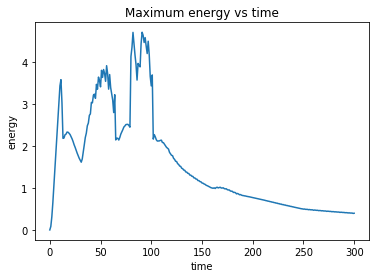

In [19]:
# plot max energy vs time
data = np.genfromtxt("energy.maximum.asc")
plt.plot(data[:,0], data[:,2])
plt.xlabel('time')
plt.ylabel('energy')
plt.title('Maximum energy vs time')

In [23]:
# animate xy-slice of energy using imshow()
import matplotlib.cm as cm
import matplotlib.animation as animation
file_data = np.genfromtxt("energy.xy.asc")

# figure properties
cmap = cm.gist_rainbow
fig_width = 6
fig_height = 6
minval = np.min(file_data[:,12])
maxval = np.max(file_data[:,12])

# time steps
time_steps = np.unique(file_data[:,0]) 

# extract data
def extract_data(t): 
    ttdata = file_data[file_data[:,0]==t, :] #find matching time blocks
    x = ttdata[:, 5]  #x coordinate in 5th column
    y = ttdata[:, 6]  #y coordinate in 6th column
    z = ttdata[:, 12] #energy in 12th column
    zi = z.reshape(len(np.unique(y)), len(np.unique(x))) #reshape
    return zi[::-1, :]

# initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
data = extract_data(time_steps[0])
plot = [ax.imshow(data, cmap=cmap, clim=(minval, maxval))]

# update plot
def update_plot(frame_number, extract_data, plot):
    plot[0].remove()
    data = extract_data(time_steps[frame_number])
    plot[0] = ax.imshow(data, cmap=cmap, clim=(minval, maxval))

# make animation
fps=3
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(extract_data, plot), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

# play animation
from IPython.display import HTML
#HTML(anim.to_html5_video())
HTML(anim.to_jshtml())

**Exercise:**

Make a copy of both "CreatingANewThorn" notebooks and edit them to create another new thorn, "LaplacianEta" which computes the Laplacian of the eta variable, which is a measure of the displacement of the surface of the water from rest. Like the "Energy" thorn, this quantity will be computed at analysis time.

The second derivative of a quantity is approximated by the finite difference formula:

$f''[x] = (f[x+dx] - 2 f[x] + f[x-dx])/dx^2 \approx ((f[x]+dx f'[x]+\frac{1}{2}dx^2 f[x]+...) - 2 f[x] + (f[x]-dx f'[x]+\frac{1}{2}dx^2 f[x]+...))/dx^2$

In terms of Cactus, f[x] and f[x+dx] might look something like this...
<pre>
  int cc = CCTK_GFINDEX3D(cctkGH,i,j,k)
  int cp1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k)
  CCTK_REAL fx = f[cc]; // If this is f[x]
  CCTK_REAL fx1 = f[cp1]; // this is f[x+dx]
</pre>

Cactus provides an additional array of integers, like cctk_lsh, called cctk_delta_space, which provides the quantities dx, dy, and dz (these are cctk_delta_space[0], cctk_delta_space[1] and cctk_delta_space[2], respecitively).

Because this is a 2-d code, the Laplacian is

$\Delta^2 \eta = \left( \frac{d^2}{dx^2} + \frac{d^2}{dy^2} \right) \eta$

Note that you will not be able to calculate the value of the Laplacian at the borders of the grid, as that would result in a segfault. Please write zeroes in the borders instead.

Note also that Funwave defines grid variables dx and dy. You can use dx[cc] (where cc = CCTK_GFINDEX3D(cctkGH,i,j,k)) in place of cctk_delta_space[0] if you want to. You CANNOT, however, redefine dx or dy.

<table><tr><td>This work sponsored by NSF grants <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1550551"> OAC 1550551</a> and <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1539567"> CCF 1539567</a></td><td><img src="https://www.nsf.gov/awardsearch/images/common/nsf_logo_bottom.png"></tr></table>